# Preparation

In [16]:
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import datetime
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np
from PIL import Image, ImageOps

In [17]:
data = "dataset"
directories = os.listdir(data)

In [18]:
def show_image(dir, name):
    list_dir = os.listdir(dir)
    sample_file = list_dir[:5]
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i, file in enumerate(sample_file):
        image_path = os.path.join(dir, file)
        img = plt.imread(image_path)
        ax[i].imshow(img)
        ax[i].set_title(name)
        ax[i].axis("off")
    plt.show()

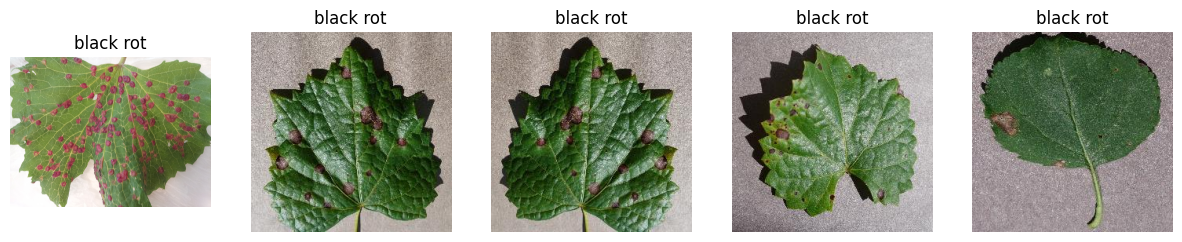

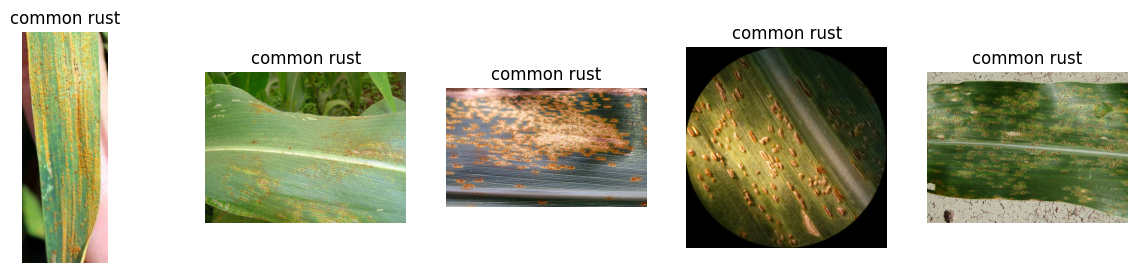

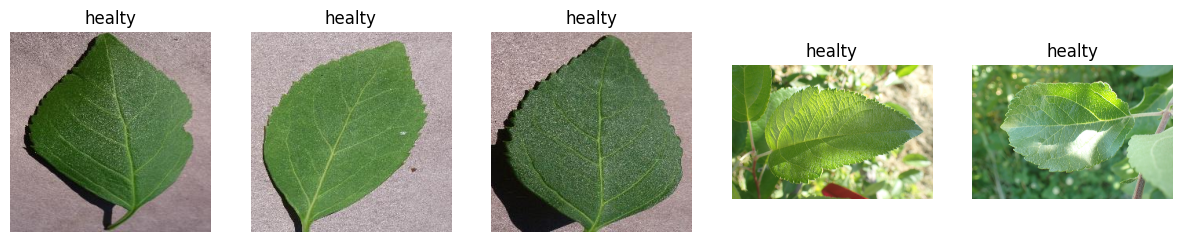

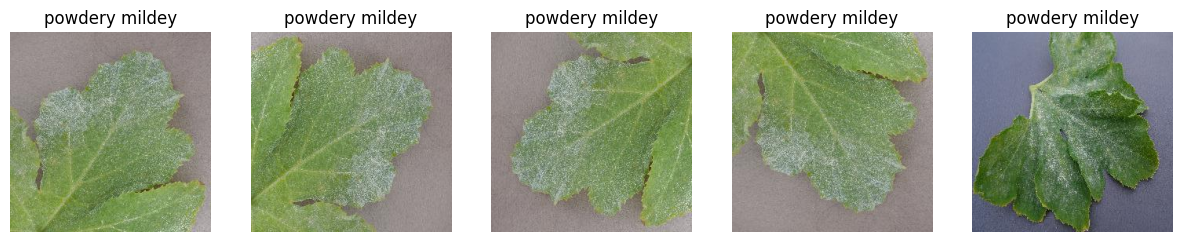

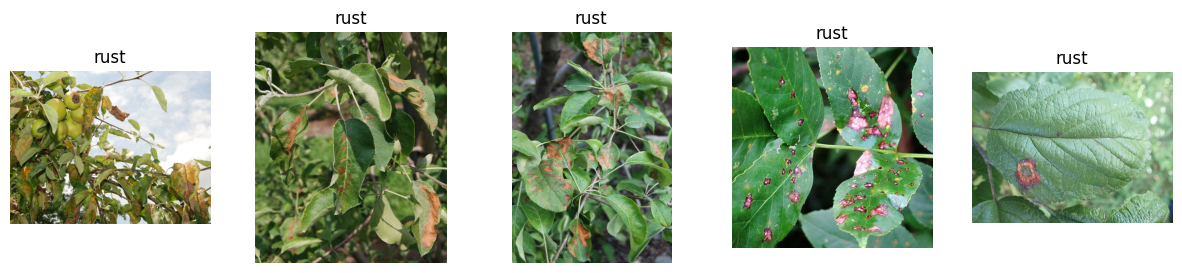

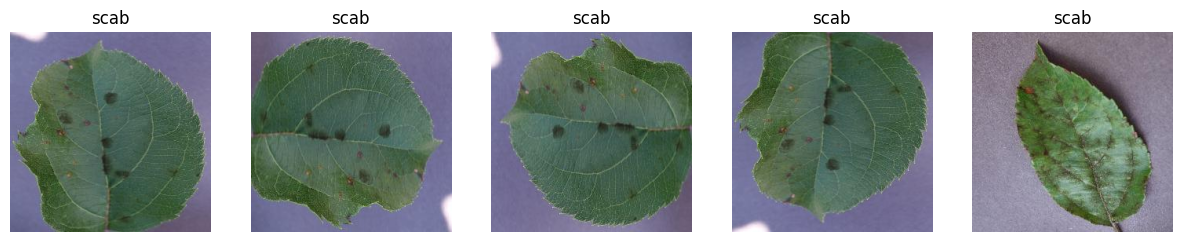

In [19]:
for directory in directories:
    show_image(os.path.join("dataset", directory), directory)

# Preprocessing

In [20]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labelst
image_df = pd.concat([filepaths, labels], axis=1)

In [21]:
image_df

,Filepath,Label
0,dataset\black rot\000gb.jpg,black rot
1,dataset\black rot\00cab05d-e87b-4cf6-87d8-284f...,black rot
2,dataset\black rot\00cab05d-e87b-4cf6-87d8-284f...,black rot
3,dataset\black rot\00cff577-afd4-4e36-ac9c-a52a...,black rot
4,dataset\black rot\00e909aa-e3ae-4558-9961-336b...,black rot
...,...,...
1205,dataset\scab\inaequalis1a.jpg,scab
1206,dataset\scab\inaequalis1b.jpg,scab
1207,dataset\scab\s-l300.jpg,scab
1208,dataset\scab\seriously-unwell-apple-tree-fruit...,scab


In [22]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [24]:
data_train = ImageDataGenerator(rescale=1./127.5,
                                rotation_range=40,
                                horizontal_flip=True,
                                vertical_flip=True)

data_test = ImageDataGenerator(rescale=1./255)

train = data_train.flow_from_dataframe(
    train_df,
    batch_size=16,
    target_size=(224, 224),
    x_col="Filepath",
    y_col="Label",
    shuffle=True,
    seed=42,
    class_mode="categorical"
)

test = data_test.flow_from_dataframe(
    test_df,
    batch_size=16,
    target_size=(224, 224),
    x_col="Filepath",
    y_col="Label",
    shuffle=False,
    seed=42,
    class_mode="categorical",
)

Found 968 validated image filenames belonging to 6 classes.
Found 242 validated image filenames belonging to 6 classes.


In [25]:
def tensorboard(name):
    logdir = os.path.join("logs", 
                          datetime.datetime.now().strftime(f"%Y-%m-%d_%H-%M_{name}"))
    return TensorBoard(logdir)

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.95):
        self.target_accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("accuracy") >= self.target_accuracy:
            print(f"\nakurasi telah tercapai {self.target_accuracy * 100}%" )
            self.model.stop_training = True

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
myCallback = myCallback(accuracy=0.96)

# Model

In [3]:
model =  load_model("model/keras_model.h5")

In [4]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 1280)              410208    
                                                                 
 sequential_7 (Sequential)   (None, 6)                 128700    
                                                                 
Total params: 538908 (2.06 MB)
Trainable params: 524828 (2.00 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


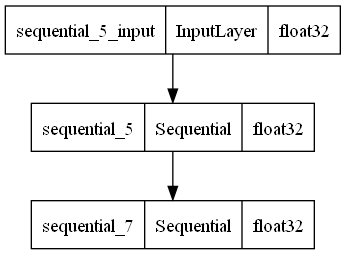

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model, "model.png", show_dtype=True)

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model("model/model.h5")
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

AttributeError: 'str' object has no attribute 'call'

# Transfer learning

In [ ]:
def create_pre_trained_mobilenet():
    pre_trained = tf.keras.applications.MobileNetV3Small(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet')
    
    for layer in pre_trained.layers:
        layer.trainable = False
    
    return pre_trained

In [ ]:
pre_trained_model = create_pre_trained_mobilenet()

In [ ]:
pre_trained_model.summary()

In [ ]:
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer("multiply_17")
    last_output = last_desired_layer.output
    return last_output

In [ ]:
last_ouput = output_of_last_layer(pre_trained_model)

In [ ]:
def create_final_model_mobilenet(pre_trained_model, last_ouput):
    x = tf.keras.layers.GlobalAveragePooling2D()(last_ouput)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(6, activation="softmax")(x)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [ ]:
model_mobilenet = create_final_model_mobilenet(pre_trained_model, last_ouput)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model_mobilenet.compile(optimizer=optimizer, 
                        loss=loss, 
                        metrics=["accuracy",
                                 tf.keras.metrics.Recall(),
                                 tf.keras.metrics.Precision()])

In [ ]:
model_mobilenet.summary()

In [ ]:
print(f"number of trainable weight: {len(model_mobilenet.trainable_weights)}")

In [ ]:
history1 = model_mobilenet.fit(train,
                    steps_per_epoch=len(train),
                    epochs=10,
                    callbacks=[callback, myCallback, tensorboard("MobileNet")])

In [ ]:
model_mobilenet.evaluate(test)

In [ ]:

true_label = test.classes
class_label = list(test.class_indices.keys())

In [ ]:
predict = model_mobilenet.predict(test)
confidence = np.argmax(predict, axis=1)

report = classification_report(true_label, confidence, target_names=class_label)
print(report)


In [ ]:
def create_pre_trained_efficiennet():
    pre_trained_model = tf.keras.applications.EfficientNetB7(
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model


In [ ]:
pre_trained_model_efficiennet = create_pre_trained_efficiennet()

In [ ]:
pre_trained_model_efficiennet.summary()

In [ ]:
def output_of_last_layer(pre_trained_model):
    last_desired = pre_trained_model.get_layer("top_activation")
    last_output = last_desired.output
    return last_output

In [ ]:
last_layer = output_of_last_layer(pre_trained_model_efficiennet)

In [ ]:
def create_final_model_efficiennet(pre_trained_model, last_layer):
    X = tf.keras.layers.Flatten()(last_layer)
    X = tf.keras.layers.Dense(256, activation="relu")(X)
    X = tf.keras.layers.Dropout(0.4)(X)
    X = tf.keras.layers.Dense(128, activation="relu")(X)
    X = tf.keras.layers.Dense(6, activation="softmax")(X)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=X)
    return model

In [ ]:
model_eficiennet = create_final_model_efficiennet(pre_trained_model_efficiennet, last_layer)

In [ ]:
model_eficiennet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy",
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

In [ ]:
history2 = model_eficiennet.fit(train,
                    steps_per_epoch=len(train),
                    epochs=10,
                    callbacks=[callback, myCallback, tensorboard("Efficiennet")])

In [ ]:
model_eficiennet.evaluate(test)

In [ ]:
predict = model_eficiennet.predict(test)
confidence = np.argmax(predict, axis=1)

report = classification_report(true_label, confidence, target_names=class_label)
print(report)

# Test

In [10]:
class_names = open("model/labels.txt", "r").readlines()

In [7]:
def test_file(dir):
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image = Image.open(dir).convert("RGB")
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
    data[0] = normalized_image_array

    # Predicts the model
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence_score = prediction[0][index]

    # Print prediction and confidence score
    
    print("kelas:", class_name[2:])
    print("Confidence:", confidence_score)

In [11]:
test_file("black rot.jpg")

1/1 [==============================] - 1s 698ms/step
kelas: Black Rot

Confidence: 0.9550504
